In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load and Prepare the Data

In [4]:
import pandas as pd
import numpy as np

# Load datasets
ad_data = pd.read_csv("raw_sample.csv", usecols=["user", "adgroup_id", "nonclk"]) 

ecommerce_data = pd.read_csv("UserBehavior.csv")

ecommerce_data.columns = ['user_id', 'item_id', 'category_id', 'behavior_type', 'timestamp']

# Rename columns for consistency
ad_data.rename(columns={"user": "user_id", "adgroup_id": "item_id", "nonclk": "interaction"}, inplace=True)
ecommerce_data["interaction"] = ecommerce_data["behavior_type"].apply(lambda x: 1 if x == "buy" else 0)  # Convert behavior to binary

# Keep only relevant columns
ad_data = ad_data[["user_id", "item_id", "interaction"]]
ecommerce_data = ecommerce_data[["user_id", "item_id", "interaction"]]

# Filter users that are present in both domains
common_users = set(ad_data["user_id"]).intersection(set(ecommerce_data["user_id"]))



ad_data = ad_data[ad_data["user_id"].isin(common_users)]
ecommerce_data = ecommerce_data[ecommerce_data["user_id"].isin(common_users)]

# Print dataset sizes
print(f"Number of common users: {len(common_users)}")
print(f"Ad interactions: {len(ad_data)}")
print(f"E-commerce interactions: {len(ecommerce_data)}")


Number of common users: 987994
Ad interactions: 22989084
E-commerce interactions: 100150806


In [5]:
# Keep only relevant columns
ad_data = ad_data[["user_id", "item_id", "interaction"]]
ecommerce_data = ecommerce_data[["user_id", "item_id", "interaction"]]

# Identify common users
common_users = list(set(ad_data["user_id"]).intersection(set(ecommerce_data["user_id"])))

# Sample 20% of common users
sample_size = int(0.3 * len(common_users))
sampled_users = np.random.choice(common_users, sample_size, replace=False)

# Filter data to only include sampled users
ad_data = ad_data[ad_data["user_id"].isin(sampled_users)]
ecommerce_data = ecommerce_data[ecommerce_data["user_id"].isin(sampled_users)]

# Print dataset sizes
print(f"Sampled users: {len(sampled_users)}")
print(f"Ad interactions after sampling: {len(ad_data)}")
print(f"E-commerce interactions after sampling: {len(ecommerce_data)}")


Sampled users: 296398
Ad interactions after sampling: 6879657
E-commerce interactions after sampling: 30066651


# Train User Embeddings in Each Domain

In [6]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

def train_user_embeddings(data, embedding_dim=32):
    data = data.groupby(["user_id", "item_id"]).agg({"interaction": "sum"}).reset_index()
    user_mapping = {user: idx for idx, user in enumerate(data["user_id"].unique())}
    item_mapping = {item: idx for idx, item in enumerate(data["item_id"].unique())}
    data["user_idx"] = data["user_id"].map(user_mapping)
    data["item_idx"] = data["item_id"].map(item_mapping)

    interaction_matrix = csr_matrix(
        (data["interaction"], (data["user_idx"], data["item_idx"])),
        shape=(len(user_mapping), len(item_mapping))
    )

    svd = TruncatedSVD(n_components=embedding_dim, random_state=42)
    user_embeddings = svd.fit_transform(interaction_matrix)

    return {user: embedding for user, embedding in zip(user_mapping.keys(), user_embeddings)}


# Train embeddings
source_user_embeddings = train_user_embeddings(ad_data)
target_user_embeddings = train_user_embeddings(ecommerce_data)

print(f"Number of users with embeddings: {len(source_user_embeddings)}")


Number of users with embeddings: 296398


# Train an MLP to Map User Embeddings from Source → Target

In [7]:
# 🔹 Step 4: Prepare Data for MLP Training
X_train, Y_train = [], []
for user in sampled_users:
    if user in source_user_embeddings and user in target_user_embeddings:
        X_train.append(source_user_embeddings[user])
        Y_train.append(target_user_embeddings[user])

X_train, Y_train = np.array(X_train), np.array(Y_train)

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
# Normalize embeddings
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
Y_train = scaler.fit_transform(Y_train)

# Convert to tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
Y_train_torch = torch.tensor(Y_train, dtype=torch.float32)

# Split train/test (80/20)
train_size = int(0.8 * len(X_train_torch))
X_train_torch, X_test_torch = X_train_torch[:train_size], X_train_torch[train_size:]
Y_train_torch, Y_test_torch = Y_train_torch[:train_size], Y_train_torch[train_size:]

In [18]:
# 🔹 Step 5: Define Optimized MLP Model
class EmbeddingMapper(nn.Module):
    def __init__(self, input_dim=32, hidden_dim=128, output_dim=32):
        super(EmbeddingMapper, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.2)  # Ajout du dropout
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)  # Appliquer Dropout après la première couche
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)  # Appliquer Dropout après la deuxième couche
        x = self.fc3(x)
        return x


model = EmbeddingMapper()

In [19]:
# 🔹 Step 6: Train Model with Cosine Similarity Loss
def cosine_similarity_loss(y_pred, y_true):
    return 1 - torch.nn.functional.cosine_similarity(y_pred, y_true).mean()

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

In [20]:
import torch

# Early Stopping Parameters
patience = 10  # Nombre d'epochs à attendre après une amélioration
min_delta = 1e-4  # Amélioration minimale considérée comme significative
best_loss = float('inf')
stopping_counter = 0

X_train_torch += torch.normal(mean=0, std=0.01, size=X_train_torch.shape)

# Train
epochs = 30
train_losses, test_losses = [], []
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X_train_torch)
    loss = cosine_similarity_loss(output, Y_train_torch)
    loss.backward()

    # Gradient Clipping pour éviter les mises à jour extrêmes
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    train_losses.append(loss.item())

    with torch.no_grad():
        test_output = model(X_test_torch)
        test_loss = cosine_similarity_loss(test_output, Y_test_torch)
        test_losses.append(test_loss.item())

    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    # Early Stopping Logic
    if test_loss < best_loss - min_delta:
        best_loss = test_loss
        stopping_counter = 0  # Réinitialiser le compteur d'arrêt
        torch.save(model.state_dict(), "embedding_mapper.pth")  # Sauvegarde du meilleur modèle
    else:
        stopping_counter += 1

    if stopping_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

    # Mise à jour du scheduler
    scheduler.step(test_loss)


Epoch 1, Train Loss: 1.0547, Test Loss: 0.9680
Epoch 2, Train Loss: 0.9763, Test Loss: 0.8977
Epoch 3, Train Loss: 0.8978, Test Loss: 0.8198
Epoch 4, Train Loss: 0.8292, Test Loss: 0.7681
Epoch 5, Train Loss: 0.7683, Test Loss: 0.7064
Epoch 6, Train Loss: 0.7153, Test Loss: 0.6650
Epoch 7, Train Loss: 0.6643, Test Loss: 0.6232
Epoch 8, Train Loss: 0.6196, Test Loss: 0.5857
Epoch 9, Train Loss: 0.5843, Test Loss: 0.5518
Epoch 10, Train Loss: 0.5513, Test Loss: 0.5294
Epoch 11, Train Loss: 0.5241, Test Loss: 0.5051
Epoch 12, Train Loss: 0.4992, Test Loss: 0.4806
Epoch 13, Train Loss: 0.4766, Test Loss: 0.4603
Epoch 14, Train Loss: 0.4557, Test Loss: 0.4430
Epoch 15, Train Loss: 0.4387, Test Loss: 0.4293
Epoch 16, Train Loss: 0.4233, Test Loss: 0.4117
Epoch 17, Train Loss: 0.4080, Test Loss: 0.3989
Epoch 18, Train Loss: 0.3959, Test Loss: 0.3855
Epoch 19, Train Loss: 0.3855, Test Loss: 0.3786
Epoch 20, Train Loss: 0.3730, Test Loss: 0.3686
Epoch 21, Train Loss: 0.3633, Test Loss: 0.3578
E

In [21]:
# 🔹 Step 7: Evaluate Performance
with torch.no_grad():
    predicted_embeddings = model(X_test_torch).numpy()
    actual_embeddings = Y_test_torch.numpy()

mse = mean_squared_error(actual_embeddings, predicted_embeddings)
mae = mean_absolute_error(actual_embeddings, predicted_embeddings)
r2 = r2_score(actual_embeddings, predicted_embeddings)

cos_similarities = np.diag(cosine_similarity(predicted_embeddings, actual_embeddings))
auc_score = roc_auc_score((cos_similarities >= 0.8).astype(int), cos_similarities)

print(f"\n🔹 Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Average Cosine Similarity: {np.mean(cos_similarities):.4f}")
print(f"AUC Score: {auc_score:.4f}")


🔹 Evaluation Metrics:
Mean Squared Error (MSE): 1.3575
Mean Absolute Error (MAE): 0.2593
R² Score: -9.0499
Average Cosine Similarity: 0.7014
AUC Score: 1.0000


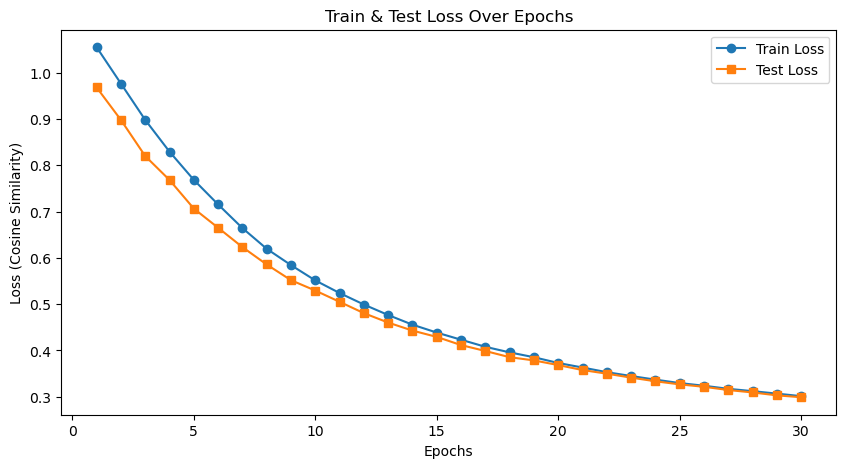

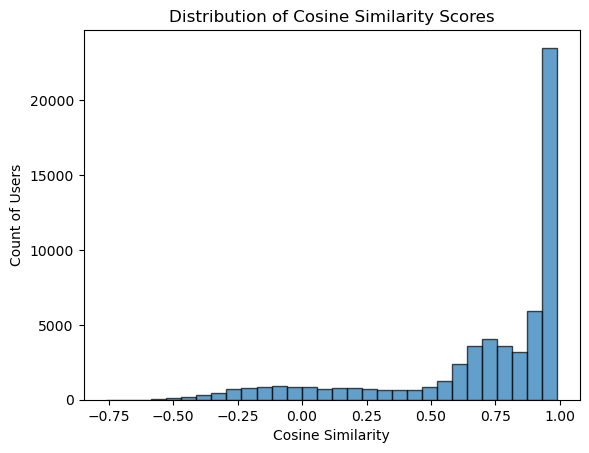

In [22]:
# 🔹 Step 8: Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, epochs + 1), test_losses, label="Test Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss (Cosine Similarity)")
plt.title("Train & Test Loss Over Epochs")
plt.legend()
plt.show()

plt.hist(cos_similarities, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Cosine Similarity")
plt.ylabel("Count of Users")
plt.title("Distribution of Cosine Similarity Scores")
plt.show()

# Use Mapped User Embeddings for E-commerce Recommendations